Librerias

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
from PIL import Image

In [2]:

# Ruta donde están las imágenes
dataset_dir = "./cifar10/train"

# Crear carpetas para train, val y test
base_dir = "cifar10Nuevo"

Esta parte del código se encarga de a partir de un conjunto de imagenes en carpetas divididas en n clases 

In [3]:
test_size = 0.2
val_size=0.2
image_size = 32
color_mode="rgb" #"grayscale", "rgba"
batch_size = 32

In [6]:


os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

# Listar clases (carpetas)
classes = os.listdir(dataset_dir)

for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    
    # Dividir en train y temp (que luego se dividirá en val y test)
    train_images, temp_images = train_test_split(images, test_size=test_size*2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(val_size*2)+0.1, random_state=42)  # 20% para val y 20% para test
    
    # Crear carpetas de clase en train, val y test
    os.makedirs(os.path.join(base_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', class_name), exist_ok=True)
    
    # Mover las imágenes a sus respectivas carpetas
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, 'train', class_name, img))
        
    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, 'val', class_name, img))
        
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, 'test', class_name, img))


2024-08-21 16:39:20.928427: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 16:39:21.147554: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 16:39:21.361485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:39:21.537334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:39:21.586110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 16:39:24.087044: W tensorflow/compiler/tf2tensorrt/utils/p

Data Augmentation

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,                # Normalización de imágenes
    rotation_range=20,             # Rotar hasta 20 grados
    width_shift_range=0.2,         # Desplazamiento horizontal
    height_shift_range=0.2,        # Desplazamiento vertical
    shear_range=0.2,               # Cizallamiento
    zoom_range=0.2,                # Zoom aleatorio
    horizontal_flip=True,          # Flip horizontal
    fill_mode='nearest'            # Método de relleno para píxeles vacíos
)

Lectura de datos

In [5]:
train_ds = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode
)

# Cargar datos de validación
val_ds = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode

)

# Cargar datos de prueba
test_ds = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode

)


Found 30000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Cargar un modelo preentrenado

In [6]:
from ModelSelector import ModelSelector

# Crear una instancia de ModelSelector


selector = ModelSelector(image_size=image_size, color_space='RGB', model='efficientnet')

# Cargar el modelo especificado
selected_model = selector.load_model()

# Mostrar la arquitectura del modelo
selected_model.summary()



Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 32, 32, 3) │          0 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 16, 16,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 16, 16,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 16, 16,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 16, 16,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 16, 16,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 16, 16,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 8, 8, 64)  │      9,216 │ block1a_project_… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 8, 8, 64)  │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 8, 8, 64)  │          0 │ block2a_expand_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 8, 8, 32)  │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 8, 8, 32)  │        128 │ block2a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 8, 8, 128) │     36,864 │ block2a_project_… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 8, 8, 128) │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 8, 8, 128) │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [7]:

import tensorflow as tf
from tensorflow.keras import models, layers

# Definir el modelo
model = models.Sequential([
      
    selected_model,
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    
    # Asegúrate de que el tamaño espacial sea adecuado
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    # Capa de salida
    layers.Dense(10, activation='softmax')

])

# Mostrar un resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1, 1, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1, 1, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 1, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,406,490 (35.88 MB)

 Trainable params: 3,486,282 (13.30 MB)

 Non-trainable params: 5,920,208 (22.58 MB)

In [8]:
from tensorflow.keras.metrics import Precision,Recall,AUC,Accuracy,F1Score,FalseNegatives,FalsePositives,MeanAbsoluteError

from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img


In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
checkpoint_filepath = './ckpt_cifar/checkpoint_{epoch}.keras'
checkpoint_dir="./ckpt_cifar"

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./ckpt_cifar", histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,verbose=1)

Metricas

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Cambiar a 'sparse_categorical_crossentropy' si las etiquetas no están en formato one-hot
    metrics=[Precision(), Recall(), AUC(), Accuracy(), FalseNegatives(), FalsePositives(), MeanAbsoluteError()]
)


Train

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # Puedes ajustar el número de épocas,
    callbacks=[tensorboard_callback, model_checkpoint_callback, early_stopping]
)


Epoch 1/100


c:\Users\Sebas\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0000e+00 - auc: 0.4993 - false_negatives: 15014.7666 - false_positives: 19.3390 - loss: 2.3646 - mean_absolute_error: 0.1800 - precision: 0.1628 - recall: 4.6080e-04
Epoch 1: saving model to ./ckpt_cifar/checkpoint_1.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 166s 155ms/step - accuracy: 0.0000e+00 - auc: 0.4993 - false_negatives: 15030.7207 - false_positives: 19.3397 - loss: 2.3646 - mean_absolute_error: 0.1800 - precision: 0.1628 - recall: 4.6045e-04 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_false_negatives: 10000.0000 - val_false_positives: 0.0000e+00 - val_loss: 2.3034 - val_mean_absolute_error: 0.1800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0000e+00 - auc: 0.4999 - false_negatives: 15015.8809 - false_positives: 0.0000e+00 - loss: 2.3067 - mean_absolute_error: 0.1800 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: saving model to ./ckpt_ci

TensorBoard

In [20]:
os.environ['TENSORBOARD_BINARY'] = 'C:/Users/Sebas/.pyenv/pyenv-win/versions/3.10.11/Lib/site-packages/tensorboard/main.py'


In [24]:
from tensorboard.plugins import projector


In [23]:
! C:/Users/Sebas/.pyenv/pyenv-win/versions/3.10.11/Lib/site-packages/tensorboard/main.py --logdir './ckpt_cifar'

In [25]:
config = projector.ProjectorConfig()


In [60]:
test_acc = model.evaluate(test_ds)
print(test_acc)
formatted_string = "Values: {}".format(", ".join(map(str, test_acc)))
print(formatted_string)

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.0000e+00 - auc_8: 0.4975 - false_negatives_3: 5039.7964 - false_positives_3: 0.0000e+00 - loss: 2.3032 - mean_absolute_error: 0.1800 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00
[2.303036689758301, 0.0, 0.0, 0.5, 0.0, 10000.0, 0.0, 0.18000100553035736]
Values: 2.303036689758301, 0.0, 0.0, 0.5, 0.0, 10000.0, 0.0, 0.18000100553035736


In [61]:
y_pred=model.predict(test_ds)
y_pred_label=np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step


In [62]:
import numpy as np
import tensorflow as tf

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Obtener la clase predicha
    true_labels.extend(np.argmax(labels, axis=1))  # Obtener la clase verdadera

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

Matriz de confusión

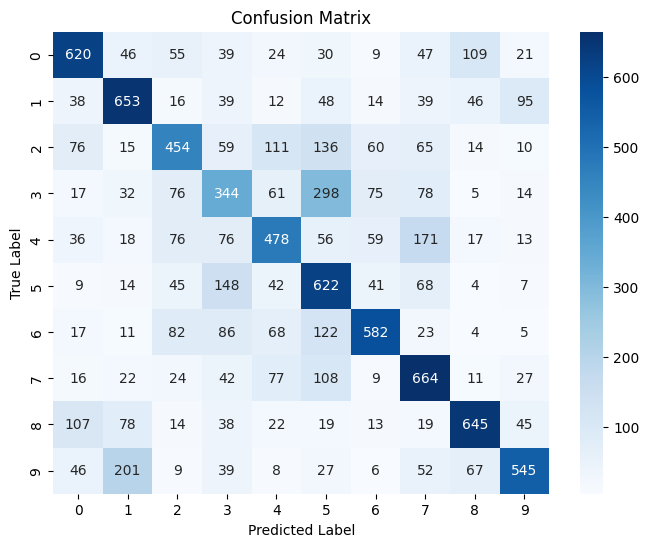

In [ ]:
# Crear la matriz de confusión
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convertir a numpy para facilitar la visualización
cm = cm.numpy()

# Visualizar la matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


C:\Users\Sebas\AppData\Local\Temp\ipykernel_1804\1775932765.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3),


Predict

In [12]:

latest=tf.keras.models.load_model("./ckpt_cifar/checkpoint_100.keras")
latest.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1, 1, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1, 1, 256)      │     2,212,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 1, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,244,256 (42.89 MB)

 Trainable params: 2,749,002 (10.49 MB)

 Non-trainable params: 2,997,248 (11.43 MB)

 Optimizer params: 5,498,006 (20.97 MB)

In [16]:
import numpy as np
import tensorflow as tf

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    preds = latest.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Obtener la clase predicha
    true_labels.extend(np.argmax(labels, axis=1))  # Obtener la clase verdadera

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

2024-08-25 18:03:41.808408: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
